### Model 1 --- NetMHCpan1.0

##### 训练模型

epoch-1 training finished , loss_ave_train = 0.2503
epoch-1 testing finished , loss_ave_val = 0.1995
epoch-2 training finished , loss_ave_train = 0.2063
epoch-2 testing finished , loss_ave_val = 0.1898
epoch-3 training finished , loss_ave_train = 0.1941
epoch-3 testing finished , loss_ave_val = 0.1873
epoch-4 training finished , loss_ave_train = 0.1882
epoch-4 testing finished , loss_ave_val = 0.1864
epoch-5 training finished , loss_ave_train = 0.1829
epoch-5 testing finished , loss_ave_val = 0.1855
epoch-6 training finished , loss_ave_train = 0.1796
epoch-6 testing finished , loss_ave_val = 0.1850
epoch-7 training finished , loss_ave_train = 0.1766
epoch-7 testing finished , loss_ave_val = 0.1846
epoch-8 training finished , loss_ave_train = 0.1743
epoch-8 testing finished , loss_ave_val = 0.1848
epoch-9 training finished , loss_ave_train = 0.1725
epoch-9 testing finished , loss_ave_val = 0.1848
epoch-10 training finished , loss_ave_train = 0.1709
epoch-10 testing finished , loss_ave_v

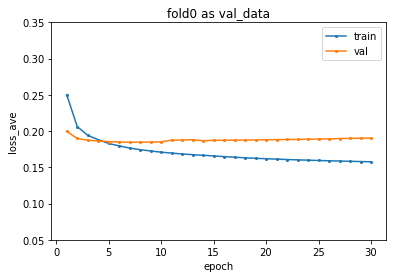

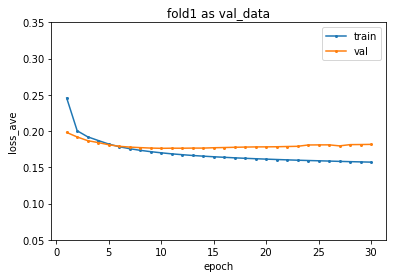

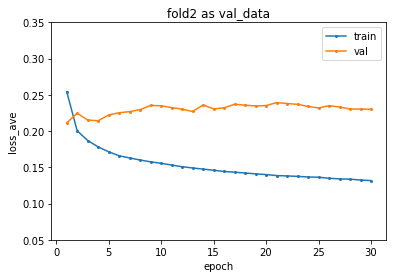

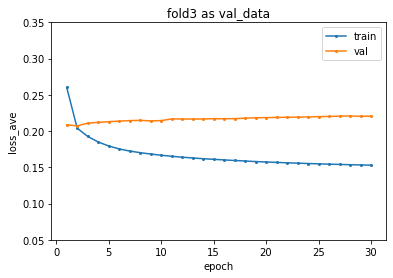

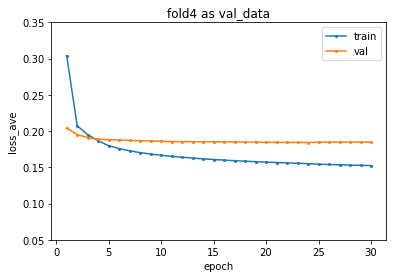

In [70]:
import pandas as pd
import numpy as np

import torch
import task_models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

'''BLOSUM50'''
BLOSUM50_Matrix = pd.read_table('BLOSUM50_Matrix.txt',sep = '\s+')          #用\s+,如果用\t会让txt中第一列会被当作数据
amino_acid_sort = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','J','Z','X']    #X可以用于padding
amino_acid_num = len(amino_acid_sort)
BLOSUM50_Matrix = BLOSUM50_Matrix.loc[amino_acid_sort, amino_acid_sort]     #去掉BLOSUM50中的*

'''训练'''
#参数
pep_len_max = 14
HLA_len = 34

input_size = (pep_len_max + HLA_len) * amino_acid_num   #pHLA编码长度
hidden_size = 60                                        #22-86 from paper
output_size = 1                                         #a single neroun

fold = 5
epoch_num = 30
learning_rate = 0.001

#设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')       #有GPU就用GPU

loss_val_sum = []           #保存每个epoch中，5个模型平均评估loss之和，用于计算最后的平均结果

#开始 5fold-cv 训练
for f in range(fold):

    #模型
    model = task_models.NetMHCpan_10(input_size, hidden_size, output_size).to(device)

    #优化方式
    loss_fn = nn.MSELoss()                                               #MSE-loss
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)       #Adam优化方式

    train_data_num = [n for n in range(fold)]   #训练数据编号
    train_data_num.pop(f)                       #拿出一组训练数据用于评估，其余用于训练

    loss_ave_train = []         #保存每个epoch的平均训练loss
    loss_ave_val = []           #保存每个epoch的平均评估loss

    #训练30个epoch
    for e in range(epoch_num):

        #训练模型
        loss_all_train = []       #保存1个epoch中每个数据的loss

        #用训练数据训练
        for ff in train_data_num:
            '''提取数据'''
            pep_data = pd.read_csv("data_csv/train_data_fold{}.csv".format(ff),usecols=["peptide","length"]) 
            HLA_data = pd.read_csv("data_csv/train_data_fold{}.csv".format(ff),usecols=["HLA_sequence"]) 
            bind_data = pd.read_csv("data_csv/train_data_fold{}.csv".format(ff),usecols=["label"]) 

            pep_seq, pep_len = np.array(pep_data["peptide"]), np.array(pep_data["length"])
            HLA_seq = np.array(HLA_data["HLA_sequence"])
            bind_label = np.array(bind_data["label"])

            data_num = bind_label.size          #数据数量

            for i in range(data_num):

                '''编码'''
                pHLA_code = np.zeros((HLA_len+pep_len_max, amino_acid_num))

                for j in range(pep_len[i]):
                    pHLA_code[j,:] = BLOSUM50_Matrix[pep_seq[i][j]]             #先对peptide编码

                for j in range(pep_len[i], pep_len_max):
                    pHLA_code[j,:] = BLOSUM50_Matrix['X']                       #peptide长度不足14，padding，用X编码 

                for j in range(HLA_len):
                    pHLA_code[j+pep_len_max,:] = BLOSUM50_Matrix[HLA_seq[i][j]] #最后对HLA序列编码，放在后面
                
                pHLA_code = pHLA_code.reshape(-1, input_size)                   #转为1*1152数组

                '''前向传播，得到预测与误差'''
                pHLA_code = torch.Tensor(pHLA_code).to(device)                  #输入GPU
                target = bind_label[i]
                target = target.reshape(-1,1)
                target = torch.Tensor(target).to(device, dtype = torch.float)   #MSE backward()中要求是float，不是long

                prediction = model(pHLA_code)
                loss = loss_fn(prediction, target)
                loss_all_train.append(loss.item())

            #    print(prediction)
            #    print(target)
            #    print(loss)

                '''后向传播，更新模型参数'''
                optimizer.zero_grad()   #梯度清零
                loss.backward()         #计算梯度
                optimizer.step()        #更新参数

        loss_ave_train.append(np.mean(loss_all_train))          #对所有数据的loss取平均
        print('epoch-{} training finished , loss_ave_train = {:.4f}'.format(e+1, np.mean(loss_all_train)))


        #用剩余的一组数据评估模型
        loss_all_val = []       #保存1个epoch中每个数据的loss

        '''提取数据'''
        pep_data = pd.read_csv("data_csv/train_data_fold{}.csv".format(f),usecols=["peptide","length"]) 
        HLA_data = pd.read_csv("data_csv/train_data_fold{}.csv".format(f),usecols=["HLA_sequence"]) 
        bind_data = pd.read_csv("data_csv/train_data_fold{}.csv".format(f),usecols=["label"]) 

        pep_seq, pep_len, pep_len_max= np.array(pep_data["peptide"]), np.array(pep_data["length"]), 14
        HLA_seq, HLA_len = np.array(HLA_data["HLA_sequence"]), 34
        bind_label = np.array(bind_data["label"])

        data_num = bind_label.size          #数据数量

        for i in range(data_num):

            '''编码'''
            pHLA_code = np.zeros((HLA_len+pep_len_max, amino_acid_num))

            for j in range(pep_len[i]):
                pHLA_code[j,:] = BLOSUM50_Matrix[pep_seq[i][j]]             #先对peptide编码

            for j in range(pep_len[i], pep_len_max):
                pHLA_code[j,:] = BLOSUM50_Matrix['X']                       #peptide长度不足14，padding，用X编码 

            for j in range(HLA_len):
                pHLA_code[j+pep_len_max,:] = BLOSUM50_Matrix[HLA_seq[i][j]] #最后对HLA序列编码，放在后面
                
            pHLA_code = pHLA_code.reshape(-1, input_size)                   #转为1*1152数组

            '''前向传播，得到预测与误差'''
            pHLA_code = torch.Tensor(pHLA_code).to(device)                  #输入GPU
            target = bind_label[i]
            target = target.reshape(-1,1)
            target = torch.Tensor(target).to(device, dtype = torch.float)   #MSE backward()中要求是float，不是long

            prediction = model(pHLA_code)
            loss = loss_fn(prediction, target)
            loss_all_val.append(loss.item())

        loss_ave_val.append(np.mean(loss_all_val))
        print('epoch-{} testing finished , loss_ave_val = {:.4f}'.format(e+1, np.mean(loss_all_val)))
    
    loss_val_sum += loss_ave_val

    #作图，画出loss-epoch折线
    epoch = [e+1 for e in range(epoch_num)]

    plt.figure(f+1)
    plt.plot(epoch, loss_ave_train, marker='o', markersize=2)
    plt.plot(epoch, loss_ave_val, marker='o', markersize=2)
    plt.ylim(0.05, 0.35)
    plt.legend(['train','val'])
    plt.xlabel('epoch'),plt.ylabel('loss_ave')
    plt.title("fold{} as val_data".format(f))

    #保存当前模型
    torch.save(model, "model/NetMHCpan_10_fold{}.pkl".format(f))
    print("***get the model NetMHCpan_10_fold{}***".format(f))


Text(0.5, 1.0, "model's validation result")

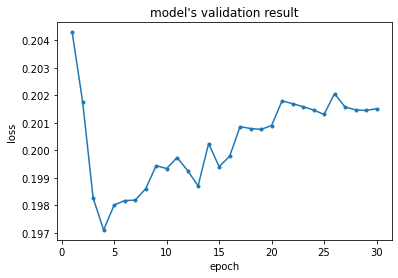

In [76]:
#平均评估loss
epoch = [e+1 for e in range(epoch_num)]
loss_val_ave = []
for e in range(epoch_num):
    sum = 0
    for n in range(fold):
        sum += loss_val_sum[n*epoch_num + e]
    loss_val_ave.append(sum/fold)
plt.figure(fold+1)
plt.plot(epoch, loss_val_ave, marker='o', markersize=3)
plt.xlabel('epoch'),plt.ylabel('loss')
plt.title("model's validation result")

##### 在其他data_set上的accuracy

In [17]:
#independent_set
import pandas as pd
import numpy as np
import torch

'''BLOSUM50'''
BLOSUM50_Matrix = pd.read_table('BLOSUM50_Matrix.txt',sep = '\s+')          #用\s+,如果用\t会让txt中第一列会被当作数据
amino_acid_sort = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','J','Z','X']    #X可以用于padding
amino_acid_num = len(amino_acid_sort)
BLOSUM50_Matrix = BLOSUM50_Matrix.loc[amino_acid_sort, amino_acid_sort]     #去掉BLOSUM50中的*

#参数
pep_len_max = 14
HLA_len = 34

input_size = (pep_len_max + HLA_len) * amino_acid_num   #pHLA编码长度
hidden_size = 60                                        #22-86 from paper
output_size = 1                                         #a single neroun

fold = 5

#设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')       #有GPU就用GPU

'''提取数据'''
pep_data = pd.read_csv("data_csv/independent_set2.csv",usecols=["peptide","length"]) 
HLA_data = pd.read_csv("data_csv/independent_set2.csv",usecols=["HLA_sequence"]) 
bind_data = pd.read_csv("data_csv/independent_set2.csv",usecols=["label"]) 

pep_seq, pep_len, pep_len_max= np.array(pep_data["peptide"]), np.array(pep_data["length"]), 14
HLA_seq, HLA_len = np.array(HLA_data["HLA_sequence"]), 34
bind_label = np.array(bind_data["label"])

data_num = bind_label.size          #数据数量

'''加载模型'''
use_model = torch.load("model/NetMHCpan_10_fold2.pkl")

'''预测'''
pre_result = np.zeros(data_num)

for i in range(data_num):

    '''编码'''
    pHLA_code = np.zeros((HLA_len+pep_len_max, amino_acid_num))

    for j in range(pep_len[i]):
        pHLA_code[j,:] = BLOSUM50_Matrix[pep_seq[i][j]]             #先对peptide编码

    for j in range(pep_len[i], pep_len_max):
        pHLA_code[j,:] = BLOSUM50_Matrix['X']                       #peptide长度不足14，padding，用X编码 

    for j in range(HLA_len):
        pHLA_code[j+pep_len_max,:] = BLOSUM50_Matrix[HLA_seq[i][j]] #最后对HLA序列编码，放在后面

    pHLA_code = pHLA_code.reshape(-1, input_size)                   #转为1*1152数组

    '''前向传播，得到预测'''
    pHLA_code = torch.Tensor(pHLA_code).to(device)                  #输入GPU
    target = bind_label[i]
    target = target.reshape(-1,1)
    target = torch.Tensor(target).to(device, dtype = torch.float)   #MSE backward()中要求是float，不是long

    prediction = use_model(pHLA_code)
    pre_result[i] = prediction.item()

'''probability--->binding(1) or non-binding(0)'''
pre_result[pre_result >= 0.5] = 1
pre_result[pre_result < 0.5] = 0

'''prediction与label比较'''
pre_result[pre_result != bind_label] = 0    #用pre_result保存比较结果
pre_result[pre_result == bind_label] = 1

correct_num = np.sum(pre_result)
accuracy = correct_num/data_num
print("accuracy on independent_set is {:.4f}".format(accuracy))

accuracy on independent_set is 0.9156


In [18]:
#external_set
'''BLOSUM50'''
BLOSUM50_Matrix = pd.read_table('BLOSUM50_Matrix.txt',sep = '\s+')          #用\s+,如果用\t会让txt中第一列会被当作数据
amino_acid_sort = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','J','Z','X']    #X可以用于padding
amino_acid_num = len(amino_acid_sort)
BLOSUM50_Matrix = BLOSUM50_Matrix.loc[amino_acid_sort, amino_acid_sort]     #去掉BLOSUM50中的*

'''提取数据'''
pep_data = pd.read_csv("data_csv/external_set2.csv",usecols=["peptide","length"]) 
HLA_data = pd.read_csv("data_csv/external_set2.csv",usecols=["HLA_sequence"]) 
bind_data = pd.read_csv("data_csv/external_set2.csv",usecols=["label"]) 

pep_seq, pep_len, pep_len_max= np.array(pep_data["peptide"]), np.array(pep_data["length"]), 14
HLA_seq, HLA_len = np.array(HLA_data["HLA_sequence"]), 34
bind_label = np.array(bind_data["label"])

data_num = bind_label.size          #数据数量

'''加载模型'''
use_model = torch.load("model/NetMHCpan_10_fold2.pkl")

'''预测'''
pre_result = np.zeros(data_num)

for i in range(data_num):

    '''编码'''
    pHLA_code = np.zeros((HLA_len+pep_len_max, amino_acid_num))

    for j in range(pep_len[i]):
        pHLA_code[j,:] = BLOSUM50_Matrix[pep_seq[i][j]]             #先对peptide编码

    for j in range(pep_len[i], pep_len_max):
        pHLA_code[j,:] = BLOSUM50_Matrix['X']                       #peptide长度不足14，padding，用X编码 

    for j in range(HLA_len):
        pHLA_code[j+pep_len_max,:] = BLOSUM50_Matrix[HLA_seq[i][j]] #最后对HLA序列编码，放在后面

    pHLA_code = pHLA_code.reshape(-1, input_size)                   #转为1*1152数组

    '''前向传播，得到预测'''
    pHLA_code = torch.Tensor(pHLA_code).to(device)                  #输入GPU
    target = bind_label[i]
    target = target.reshape(-1,1)
    target = torch.Tensor(target).to(device, dtype = torch.float)   #MSE backward()中要求是float，不是long

    prediction = use_model(pHLA_code)
    pre_result[i] = prediction.item()

'''probability--->binding(1) or non-binding(0)'''
pre_result[pre_result >= 0.5] = 1
pre_result[pre_result < 0.5] = 0

'''prediction与label比较'''
pre_result[pre_result != bind_label] = 0    #用pre_result保存比较结果
pre_result[pre_result == bind_label] = 1

correct_num = np.sum(pre_result)
accuracy = correct_num/data_num
print("accuracy on external_set is {}".format(accuracy))


accuracy on external_set is 0.954


fold1